# Classifiez automatiquement des biens de consommation - partie textuelle - modélisation non supervisée

## 1. Introduction

__Contexte__

Place de marché® est un e-commerce qui met direction en relation les vendeurs et les acheteurs. A ce jour, les vendeurs doivent insérer une photo, une description du produit qu'ils vendent et aussi le trier dans sa catégorie. Cependant, il arrive que ces derniers se trompent dans lorsqu'ils le catégorisent. 

__Problématiques__

C'est pourquoi Place de marché souhaite automatiser la catégorisation des produits à partir de son image et/ou de sa description avec l'aide d'un moteur de classifiation automatique.

__Droits d'utilisation des données Flipkart__

Le dossier Flipkart a été échantillonné à partir des données mises sur Kaggle, avec l'autorisation de Flipkart: comme il est visible dans cette image ci-dessous où nous voyons qu'ils sont sous la licence [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/) qui stipule qu'il est possible d'utiliser, de modifier et de partager ces données. Nous pouvons donc continuer le reste de l'étude de faisabilité sans nous soucier d'enfreindre la loi de ce côté-là. 

Cependant cela n'inclut que le dataframe. Malheureusement, j'ai beau cherché, rien n'indique que les images peuvent être utilisées: voire même Flipkart stipule dans sa page "https://affiliate.flipkart.com/terms-of-use" dans la section "Trademark, Copyright and Restriction" que nous ne pouvons pas l'utiliser sans leur autorisation. Cependant, comme ce dataset est utilisé par OpenClassrooms, j'en ai conclu qu'il était possible que je travaille sur ce dernier. 

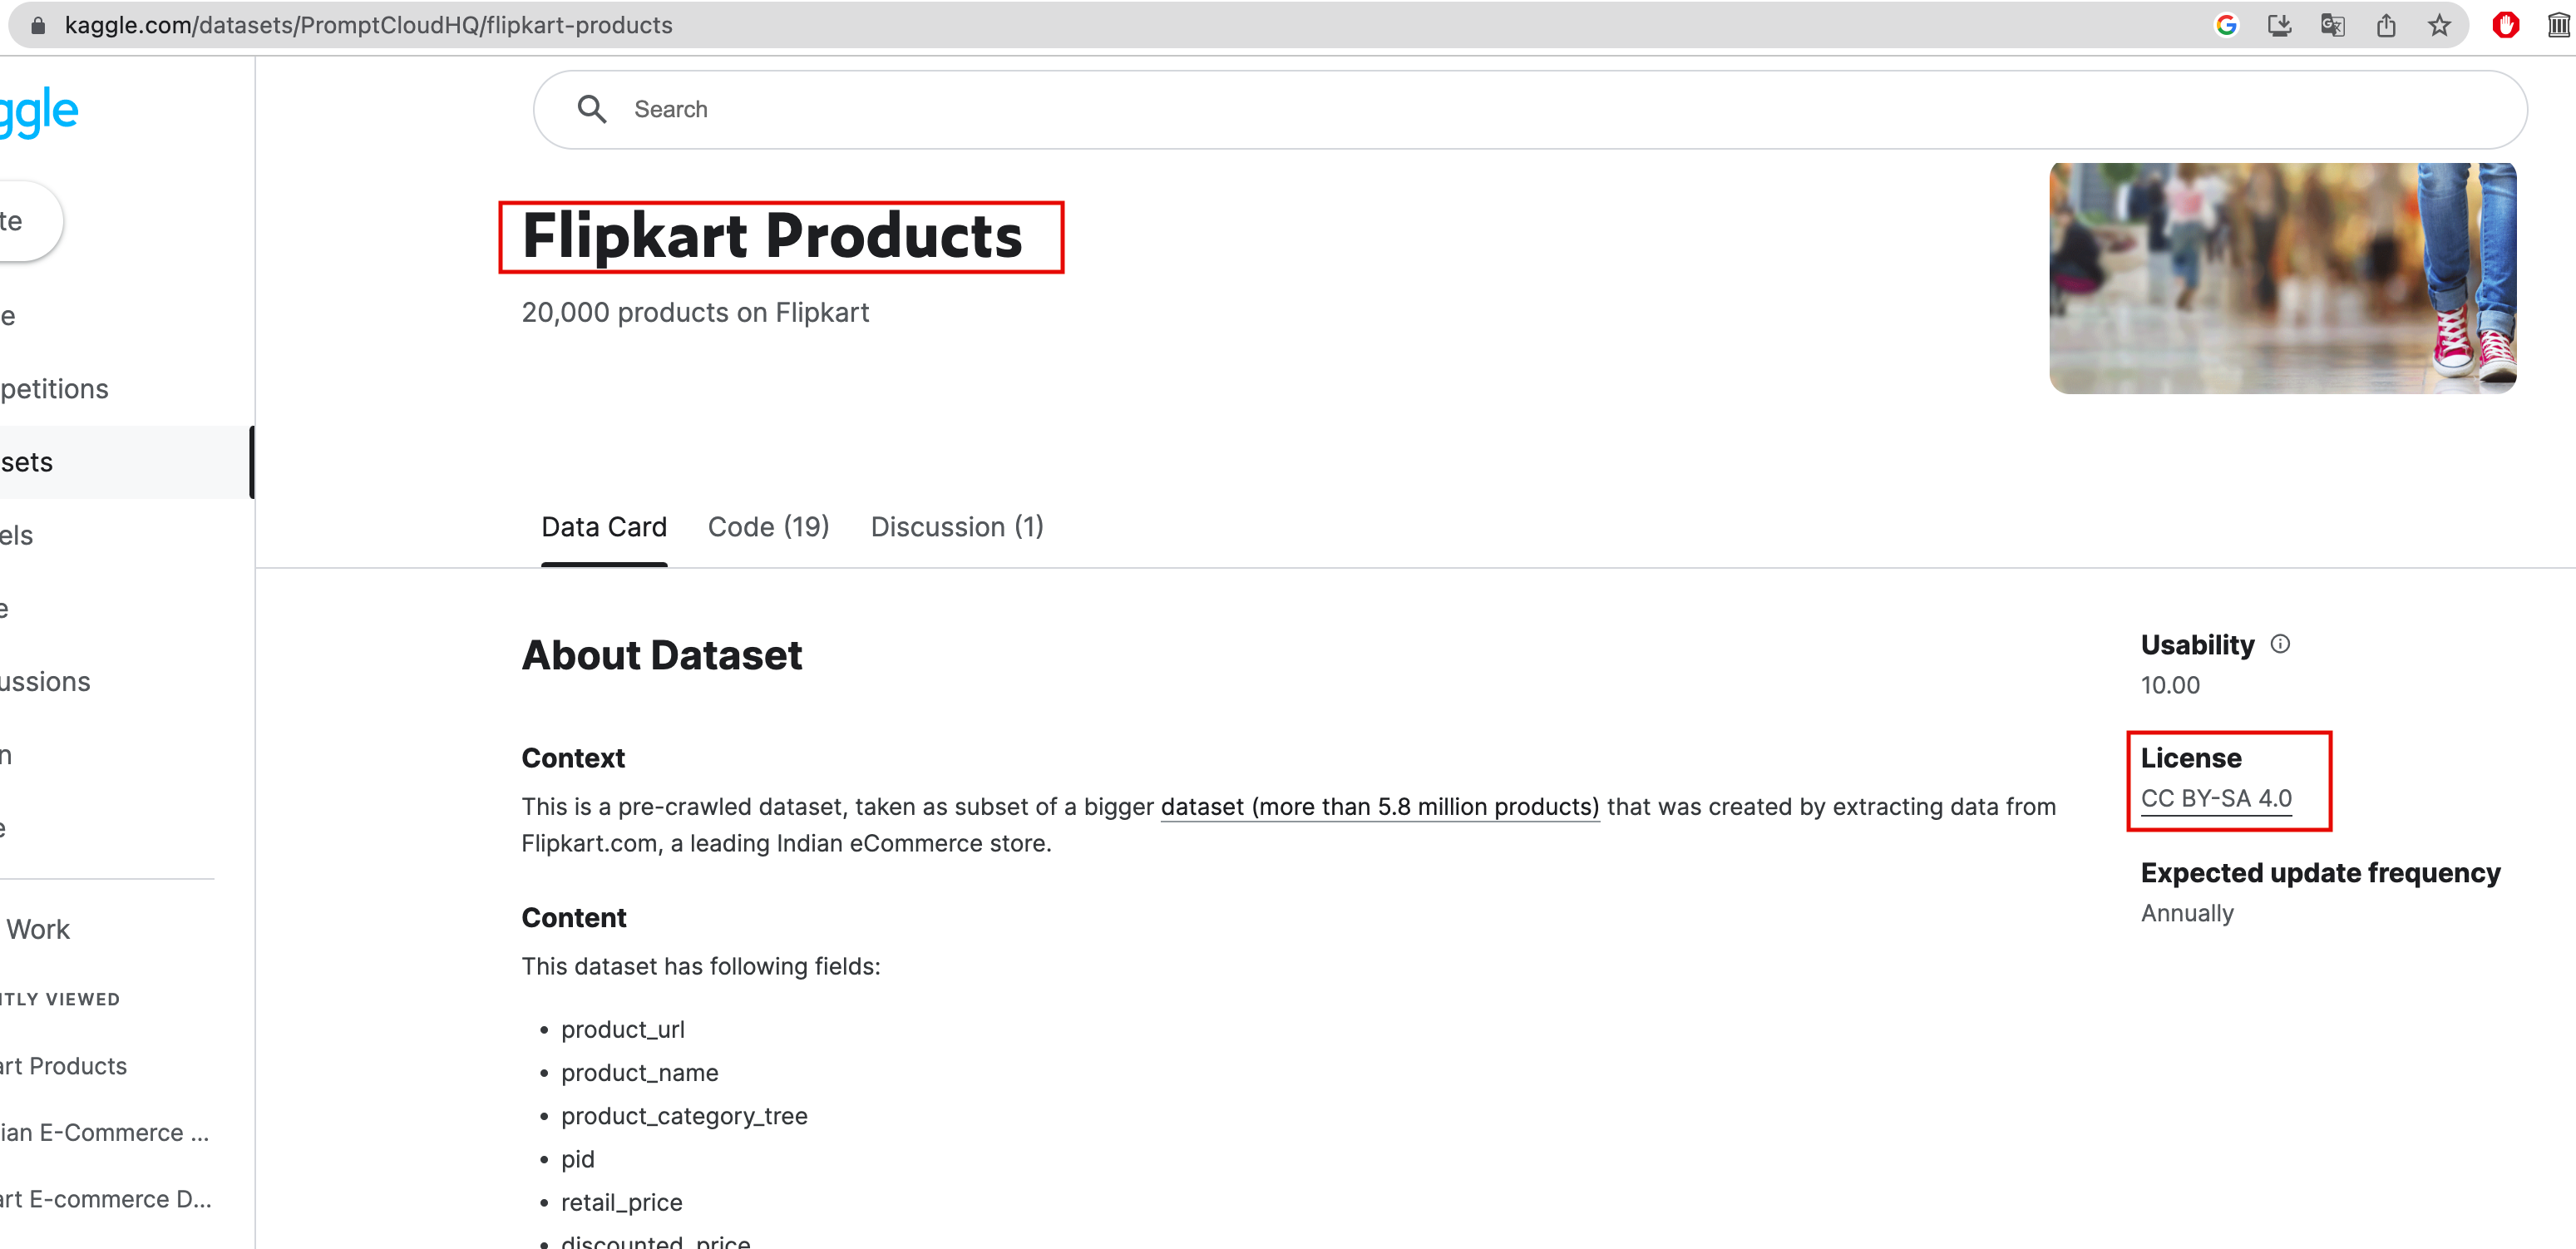

### Les critères à remplir dans ce notebook
   1. __Prétraiter des données images pour obtenir un jeu de données exploitable.__
      - CE1 Vous avez utilisé des librairies spécialisées pour un premier traitement du contraste (ex. : openCV). 
      - CE3 Vous avez élaboré une fonction permettant d'extraire des features ("feature engineering") de type "bag-of-images" via la génération de descripteurs (algorithmes ORB, ou SIFT, ou SURF). 
      - CE4 Vous avez élaboré et exécuté une fonction permettant d'extraire des features ("feature engineering") via un algorithme de Transfer Learning basé sur des réseaux de neurones, comme par exemple CNN. 

   2. __Mettre en œuvre des techniques de réduction de dimension.__
      - CE1 Vous avez justifié la nécessité de la réduction de dimension. 
      - CE2 Vous avez appliqué une méthode de réduction de dimension adaptée à la problématique (ex. : ACP). 
      - CE3 Vous avez justifié le choix des valeurs des paramètres dans la méthode de réduction de dimension retenue (ex. : le nombre de dimensions conservées pour l'ACP).  
 
   3. __Représenter graphiquement des données à grandes dimensions.__
      - CE1 Vous avez mis en œuvre au moins une technique de réduction de dimension (via LDA, ACP, T-SNE, UMAP ou autre technique).
      - CE2 Vous avez réalisé au moins un graphique représentant les données réduites en 2D (par exemple affichage des 2 composantes du T-SNE).
      - CE3 Vous avez réalisé et formalisé une analyse du graphique en 2D.

## Préparation de l'environnement

__Importation des librairies et du jeu de données__

In [2]:
ls

Terrien_Audrey_1_exploration_textuelle.ipynb
Terrien_Audrey_2_exploration_visuelle.ipynb
Terrien_Audrey_3_classification_non_supervisée_textuelle.ipynb
Terrien_Audrey_4_classification_non_supervisée_visuelle.ipynb
my_packages/


In [3]:
# Importation des librairies de base
import pandas as pd
import numpy as np
import warnings
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.preprocessing import LabelEncoder

# Importation des fonctions personnelles
import sys
sys.path.append('../my_packages') 
from my_packages import *

# Cache les warnings
warnings.filterwarnings('ignore')

In [4]:
# Importation de tensorflow pour traiter les images
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

2023-09-13 20:00:20.248325: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Check available devices (GPU or CPU)
devices = tf.config.experimental.list_physical_devices('GPU')

if len(devices) == 0: print("No GPU devices found.") 
else: print("GPU devices found:", devices)

del devices

No GPU devices found.


In [6]:
# Réimportation uniquement des données textuelles nécessaires
df = pd.read_csv(PATH_input+'flipkart_com-ecommerce_sample_1050.csv')   
df['CATEGORY'] = df['product_category_tree'].map(lambda x: x.split("[\"")[1].split(" >>", 1)[0])
df = df[['CATEGORY', 'image']]
df['image'] = PATH_resized_images + df['image']
df.columns = ['CATEGORY', 'IMAGE']
df.sample()

,CATEGORY,IMAGE
448,Baby Care,/Users/audreyterrien/Documents/github_reposito...


In [7]:
# Liste des catégories
le = LabelEncoder()
cat_list = list(np.unique(df.CATEGORY))
print("catégories : ", cat_list)

# Création du label qui sera utilisé lors de la comparaison ARI
true_label = le.fit_transform(df['CATEGORY'])

# Nombre de clusters
n_clusters = len(cat_list)

# Définir l'ordre des catégories et leurs couleurs respectives
palette = {'Baby Care': 'violet', 
           'Beauty and Personal Care': 'blue', 
           'Computers': 'gray', 
           'Home Decor & Festive Needs': 'green',
           'Home Furnishing': 'orange', 
           'Kitchen & Dining': 'red', 
           'Watches': 'brown'}
           
my_colors = ['violet', 'blue',  'gray', 'green', 'orange', 'red','brown']
my_cmap = ListedColormap(my_colors)

# Fixer les couleurs pour chaque catégorie
boundaries = np.arange(len(cat_list) + 1)
norm = BoundaryNorm(boundaries, my_cmap.N)

catégories :  ['Baby Care', 'Beauty and Personal Care', 'Computers', 'Home Decor & Festive Needs', 'Home Furnishing', 'Kitchen & Dining', 'Watches']


## Méthodes bag-of-words visuels

CE3 - Vous avez élaboré une fonction permettant d'extraire des features ("feature engineering") de type "bag-of-images" via la génération de descripteurs (algorithmes ORB, ou SIFT, ou SURF).

### SIFT

SIFT (Scale-Invariant Feature Transform) est un algorithme de traitement d'images utilisé pour extraire des caractéristiques (ou des descripteurs) uniques à partir d'images numériques. Les descripteurs extraits sont utilisés pour effectuer la correspondance de caractéristiques entre les images, pour la reconnaissance d'objets, la reconnaissance de visages, la reconstruction 3D, etc.

Les __hyperparamètres de SIFT__ dépendent de l'implémentation de l'algorithme et peuvent varier. Voici quelques-uns des hyperparamètres les plus courants:

- __nfeatures__ : nombre maximal de caractéristiques à extraire. Par défaut, nfeatures=0, ce qui signifie qu'il n'y a pas de limite.
- __nOctaveLayers__ : nombre de couches d'échelle par octave. Par défaut, nOctaveLayers=3.
- __contrastThreshold__ : seuil de contraste minimal pour détecter une caractéristique. Par défaut, contrastThreshold=0.04.
- __edgeThreshold__ : seuil d'arrêt pour éliminer les caractéristiques à proximité des bords de l'image. Par défaut, edgeThreshold=10.
- __sigma__ : écart-type du flou gaussien appliqué à l'image en entrée pour la construction de l'espace d'échelle. Par défaut, sigma=1.6.

Ces hyperparamètres peuvent être ajustés pour optimiser la performance de l'algorithme en fonction des exigences spécifiques de chaque application.

### SURF

SURF (Speeded Up Robust Features) est un algorithme de détection de points clés et de description de l'image, utilisé pour la reconnaissance d'objets et la correspondance d'images. Il a été développé par Herbert Bay, Tinne Tuytelaars et Luc Van Gool en 2006.

Les __[hyperparamètres de SURF](https://docs.opencv.org/4.x/d5/df7/classcv_1_1xfeatures2d_1_1SURF.html)__ sont les suivants :

- __hessianThreshold__ : Seuil pour supprimer les points faibles dans l'image en fonction de l'échelle de l'espace de Harris-Stephens. Les valeurs plus petites suppriment plus de points. Par défaut, hessianThreshold=100.
- __nOctaves__ : Nombre d'octaves à utiliser pour la détection des points. Par défaut, nOctaves=4.
- __nOctaveLayers__ : Nombre de couches par octave. Par défaut, nOctaveLayers=3.
- __extended__ : Si vrai, l'algorithme crée une description 128 bits de chaque point clé. Sinon, 64 bits sont utilisés. Par défaut, extended=False.
- __upright__ : Si vrai, l'algorithme n'utilise pas d'informations sur l'orientation du patch. Par défaut, upright=False.
- __surfMethod__ : Méthode utilisée pour extraire les descripteurs. Il peut s'agir de SURF, SURF_CUDA ou SURF_UPRIGHT. Par défaut, surfMethod=SURF.

Notez que SURF étant breveté, il n'est pas inclus dans certaines distributions d'OpenCV.

### ORB

ORB (Oriented FAST and Rotated BRIEF) est un descripteur d'image qui est utilisé pour la détection de points d'intérêt dans des images numériques. Contrairement aux descripteurs SIFT et SURF qui utilisent des convolutions gaussiennes, ORB utilise des filtres binaires pour détecter les points d'intérêt.

Les [hyperparamètres d'ORB](https://docs.opencv.org/3.4/db/d95/classcv_1_1ORB.html) sont les suivants :

- __nfeatures__ : spécifie le nombre de points d'intérêt à détecter. Par défaut, nfeatures=500.
- __scaleFactor__ : spécifie le facteur d'échelle entre les différentes images de l'échelle pyramidale. Par défaut, scaleFactor=1.2.
- __nlevels__ : spécifie le nombre d'échelles dans l'échelle pyramidale. Par défaut, nlevels=8.
- __edgeThreshold__ : spécifie le seuil de réponse du détecteur de coins pour éliminer les coins situés sur des bords. Par défaut, edgeThreshold=31.
- __firstLevel__ : spécifie le niveau de l'échelle pyramidale à partir duquel commencer la détection de points d'intérêt. Par défaut, firstLevel=0.
- __WTA_K__ : spécifie le nombre de points d'intérêt à comparer dans le calcul du BRIEF. Par défaut, WTA_K=2.
- __scoreType__ : spécifie le type de score pour les points d'intérêt. Par défaut, scoreType=cv.ORB_HARRIS_SCORE.
- __patchSize__ : spécifie la taille de la fenêtre de calcul de l'intensité du pixel pour le calcul de la réponse du détecteur de coins. Par défaut, patchSize=31.
- __fastThreshold__ : spécifie le seuil pour le détecteur de coins FAST. Par défaut, fastThreshold=20.

In [8]:
%%time
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16

# Chargement du modèle VGG16 pré-entraîné
model = VGG16(weights='imagenet', include_top=False)

# Résumé du modèle
model.summary()

# Prédiction des features pour chaque image
features = [] 

for image_path in df['IMAGE'][:150].tolist():
    # Charger l'image et la prétraiter
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = preprocess_input(img)

    # Effectuer la prédiction des features
    predictions = model.predict(img.reshape(1, 224, 224, 3))
    features.append(predictions.flatten())

# Convertir la liste en un tableau numpy
features = np.array(features)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

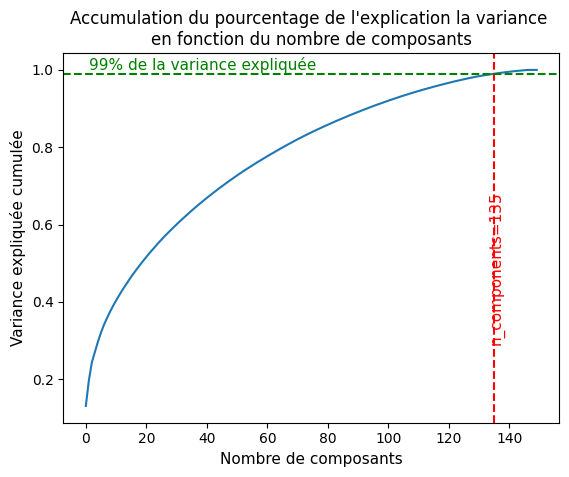

In [9]:
X_embedded, pred_label, pipeline = perform_dimensionality_reduction_Kfold(features, use_pca=True, perplexity=30, n_iter=2000, n_clusters=n_clusters, random_state=None, n_splits=3)

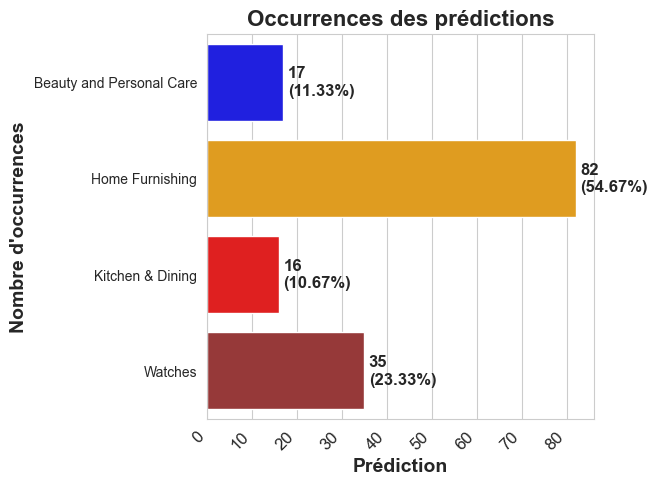

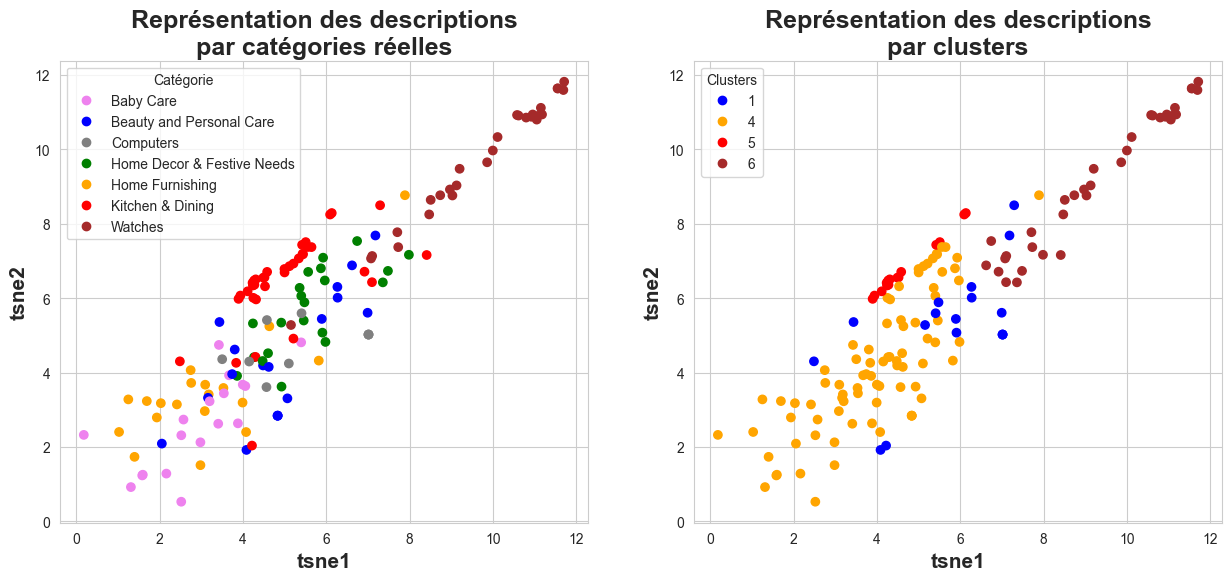

,v_measure,completeness,homogeneity,ARI
0,0.3918,0.5136,0.3167,0.1906


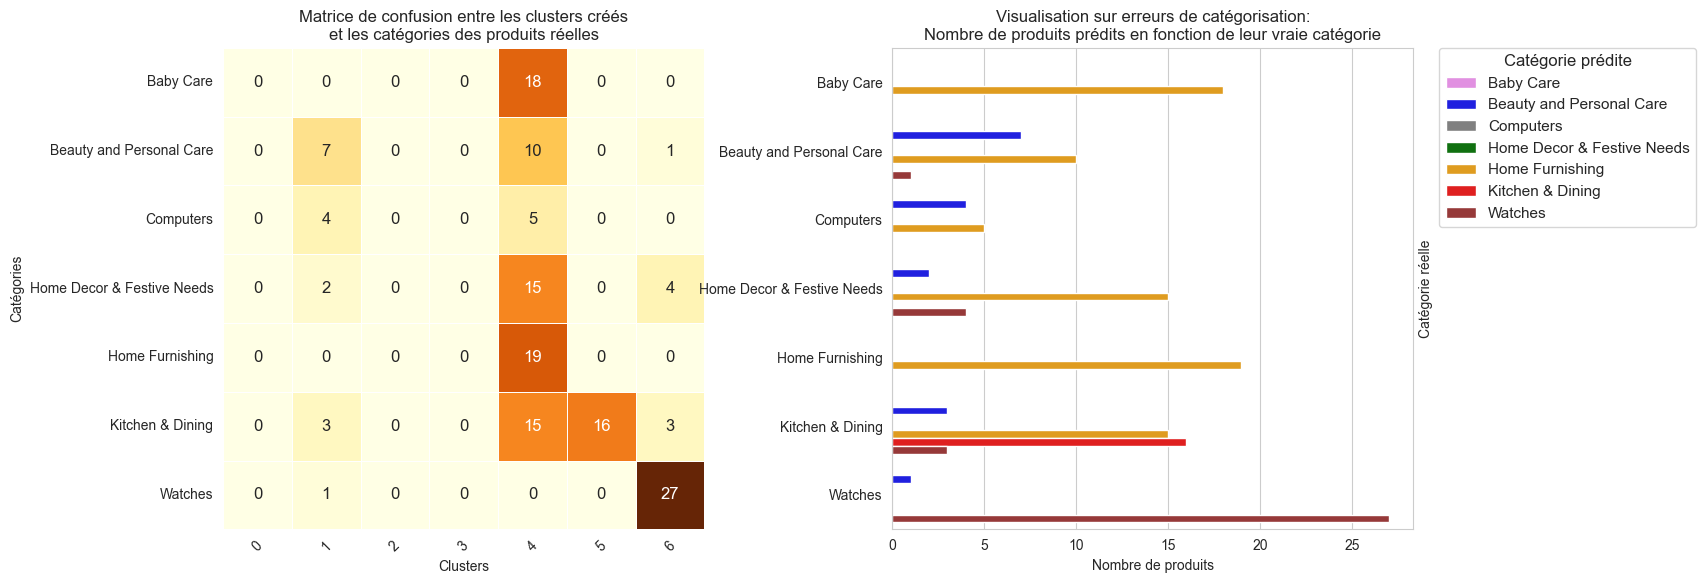

,precision,recall,f1-score,support
0,0.00,0.00,0.00,18.00
1,0.41,0.39,0.40,18.00
2,0.00,0.00,0.00,9.00
3,0.00,0.00,0.00,21.00
4,0.23,1.00,0.38,19.00
5,1.00,0.43,0.60,37.00
6,0.77,0.96,0.86,28.00
accuracy,0.46,0.46,0.46,0.46
macro avg,0.34,0.40,0.32,150.00
weighted avg,0.47,0.46,0.40,150.00


In [10]:
_,_,_ = evaluate_model('test', X_embedded, pred_label[:150], true_label[:150], le=le, my_cmap=my_cmap, norm=norm, cat_list=cat_list, palette=palette)